In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
from scipy.spatial import Delaunay

from utils import *


import matplotlib as mpl

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

# import sparse 
import scipy.sparse as sparse
# import stats
import scipy.stats as stats

def has_zero_row_or_column(matrix):
    zero_row = np.all(matrix == 0, axis=1)
    zero_column = np.all(matrix == 0, axis=0)
    return np.any(zero_row) or np.any(zero_column)

First try sigma=0.4 and 0.1

In [37]:
def generate_g(N, R, mu=1, sigma=0.2):
    g = np.random.normal(mu, sigma, (N, R))
    g = np.clip(g, a_min=0.01, a_max=1.99)
    return abs(g)

# smart diauxers with sigma=0.4
N_community = 20000
logD = log(100)
data = []
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g = generate_g(N, R, sigma=0.4)
        pref_list = smart_preference_list(g)
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"] = g, pref_list
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat(g, pref_list, dep_order, N, R)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "communities":communities})
filename = "smartdiauxer_sigma=0.4_heatmap_diagonal.pkl"
pickle.dump(data, open(filename, "wb"))

100%|██████████| 20000/20000 [13:53<00:00, 23.98it/s]


In [38]:
# smart diauxers with sigma=0.6
N_community = 20000
logD = log(100)
data = []
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g = generate_g(N, R, sigma=0.6)
        pref_list = smart_preference_list(g)
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"] = g, pref_list
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat(g, pref_list, dep_order, N, R)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "communities":communities})
filename = "smartdiauxer_sigma=0.6_heatmap_diagonal.pkl"
pickle.dump(data, open(filename, "wb"))

# smart diauxers with sigma=0.1
N_community = 20000
logD = log(100)
data = []
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g = generate_g(N, R, sigma=0.1)
        pref_list = smart_preference_list(g)
        dep_orders = allowed_orders(pref_list)
        N_dep_order = len(dep_orders)
        community["g"], community["pref_list"] = g, pref_list
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat(g, pref_list, dep_order, N, R)
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "communities":communities})
filename = "smartdiauxer_sigma=0.1_heatmap_diagonal.pkl"
pickle.dump(data, open(filename, "wb"))

100%|██████████| 20000/20000 [13:30<00:00, 24.69it/s]


In [2]:
logD = log(100)
N_community = 10000
data = {}
#sigma=0.4
data["0.4"] = [[], []]
for R in range(2, 7):
    N = R
    filename = "smartdiauxer_sigma=0.4_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
        
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"]:
                g, pref_list = item["g"], item["pref_list"]
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["0.4"][0].append(success_rate)
    data["0.4"][1].append([stability, err])
    print(stability, success_rate)

#sigma=0.6
data["0.6"] = [[], []]
for R in range(2, 7):
    N = R
    filename = "smartdiauxer_sigma=0.6_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"]:
                g, pref_list = item["g"], item["pref_list"]
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["0.6"][0].append(success_rate)
    data["0.6"][1].append([stability, err])
    print(stability, success_rate)

#sigma=0.2
data["0.2"] = [[], []]
for R in range(2, 7):
    N = R
    filename = "smart_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_dep_order"]!=[]):
            for dep_order in item["possible_dep_order"]:
                g, pref_list = item["g"], item["pref_list"]
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["0.2"][0].append(success_rate)
    data["0.2"][1].append([stability, err])
    print(stability, success_rate)

#sigma=0.05
data["0.1"] = [[], []]
for R in range(2, 7):
    N = R
    filename = "smartdiauxer_sigma=0.1_heatmap_diagonal.pkl"
    data_sub = pickle.load(open(filename, "rb"))
    communities = []
    stabilities = []
    stable = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for dep_order in item["possible_orders"]:
                g, pref_list = item["g"], item["pref_list"]
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                env = {"N":N, "R":R, "logD":logD}
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["0.1"][0].append(success_rate)
    data["0.1"][1].append([stability, err])
    print(stability, success_rate)

-0.8907495531962807 0.5011
-0.9348343931751821 0.2481
-0.9560261459150656 0.1147
-0.9658058889485338 0.0577
-0.9697933794296056 0.0267
-0.7390023957820381 0.4805
-0.8196685539937829 0.2426
-0.8537202204725476 0.115
-0.8653474666312153 0.0556
-0.8620168818096888 0.0277
-1.1156635452432992 0.4982
-1.1199446335007641 0.2414
-1.107476306266123 0.1179
-1.1169491365334832 0.0538
-1.1043009560713852 0.0248
-1.3114043821837966 0.5026
-1.2175094937641426 0.2313
-1.2317100217650296 0.1084
-1.1788732408416047 0.0501
-1.1730257772500814 0.0273


[0.0022524799205384093, -0.03376437590141819, -0.06188073080568831, -0.09604229147682951, -0.058687374639337965] [-1.3114043821837966, -1.2175094937641426, -1.2317100217650296, -1.1788732408416047, -1.1730257772500814]
[-0.0015662811355311203, -0.015202742910707194, -0.02539620791296726, -0.06509774167768603, -0.10039834085387778] [-1.1156635452432992, -1.1199446335007641, -1.107476306266123, -1.1169491365334832, -1.1043009560713852]
[0.0009543984064578865, -0.003313244399828524, -0.037346595106788755, -0.03470420418834378, -0.06833876031551878] [-0.8907495531962807, -0.9348343931751821, -0.9560261459150656, -0.9658058889485338, -0.9697933794296056]
[-0.017276612331454656, -0.013049212141483421, -0.036212172654444715, -0.05080522576201778, -0.052370252615645485] [-0.7390023957820381, -0.8196685539937829, -0.8537202204725476, -0.8653474666312153, -0.8620168818096888]


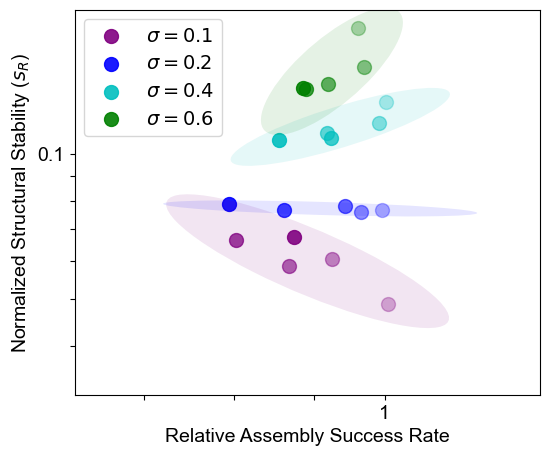

In [4]:
from matplotlib.patches import Ellipse
import matplotlib as mpl

alpha_list = np.arange(0.3, 1, 0.15)

color_list = ["purple", "b", "c", "g"]
keys_list = ["0.1", "0.2", "0.4", "0.6"]
legend_list = ["$\sigma=0.1$", "$\sigma=0.2$", "$\sigma=0.4$", "$\sigma=0.6$"]

plt.rcParams["figure.figsize"] = [6, 5]
fig, ax1 = plt.subplots()

for k_ind, k in enumerate(keys_list):
    for i in range(4):
        normalized_assembly = log10(data[k][0][i]*(2**(i+1)))
        stability = data[k][1][i][0]
        err = data[k][1][i][1]
        ax1.scatter(normalized_assembly, stability, marker='o', 
                     s=100, alpha = alpha_list[i], color=color_list[k_ind])
    for i in range(4, 5):
        normalized_assembly = log10(data[k][0][i]*(2**(i+1)))
        stability = data[k][1][i][0]
        err = data[k][1][i][1]
        ax1.scatter(normalized_assembly, stability, marker='o', 
                     s=100, alpha = alpha_list[i], color=color_list[k_ind], label=legend_list[k_ind])

for i, key in enumerate(keys_list):
    x_group, y_group = [log10(i*(2**(index+1))) for index, i in enumerate(data[key][0])], [i[0] for i in data[key][1]]
    print(x_group, y_group)
    center = np.mean([x_group, y_group], axis=1)
    cov_matrix = np.cov(x_group, y_group)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 5*np.sqrt(eigenvalues)
    ellipse = Ellipse(center, width, height, angle=angle, facecolor=color_list[i], alpha=0.1)
    ax1.add_patch(ellipse)

ax1.legend()
xlo, xhi, ylo, yhi = -0.2, 0.1, -1.5, -0.7
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(ylo, yhi)
a, b = ticking(xlo, xhi)
ax1.set_xticks(a, b)
a, b = ticking(ylo, yhi)
ax1.set_yticks(a, b)
ax1.set_xlabel("Relative Assembly Success Rate")
ax1.set_ylabel("Normalized Structural Stability ($s_R$)")
plt.savefig("figures/supp_depend_on_sigma.pdf", bbox_inches="tight")

PearsonRResult(statistic=-0.8857481361061519, pvalue=2.0667948364761272e-07)


Text(0.5, 1.0, 'p-value=2.0667948364761272e-07')

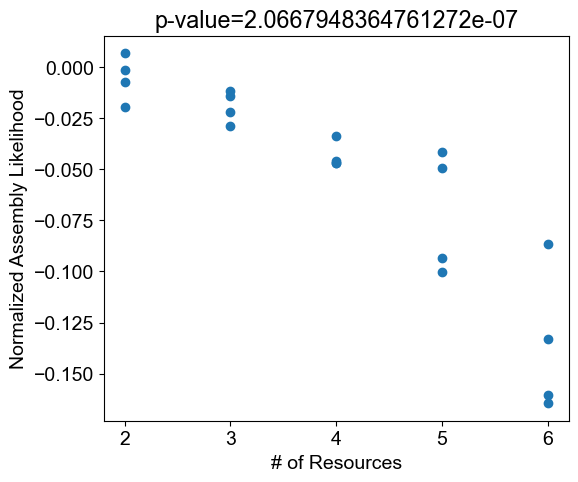

In [34]:
# p-value for assembly likelihood changing with N_R
x = []
y = []
for key in data.keys():
    x.extend([2, 3, 4, 5, 6])
    y.extend( [log10(i*(2**(index+1))) for index, i in enumerate(data[key][0])] )
print(scipy.stats.pearsonr(x, y))

plt.scatter(x, y)
plt.xlabel("# of Resources")
plt.ylabel("Normalized Assembly Likelihood")
plt.title(f"p-value={scipy.stats.pearsonr(x, y)[1]}")

In [35]:
# check if the slope has a trend
slopes = []
for i, key in enumerate(data.keys()):
    x_group, y_group = [log10(i*(2**(index+1))) for index, i in enumerate(data[key][0])], [i[0] for i in data[key][1]]
    slopes.append(scipy.stats.linregress(x_group, y_group)[0])

scipy.stats.spearmanr(range(4), slopes)

SpearmanrResult(correlation=-0.7999999999999999, pvalue=0.20000000000000007)

In [36]:
slopes

[0.3770004468804208,
 0.5778933966877221,
 -0.03189190632723029,
 -0.9978839333555533]